In [1]:
# Parameters
patient = 5
device = "cpu"


In [2]:
%config InlineBackend.figure_format = 'svg'

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pickle
from models import NonLinearController, ClosedLoopSystem
from Rens import REN_IQC_gamma, DualREN
from utils import set_params, set_QR, ensure_3d
from torch.utils.data import DataLoader, random_split, Subset
from ParametersFunctions import Parameter, PID_functions, MinMaxScalerTorch
from pathlib import Path
import scipy.io as sio
from dataset import LoadData

In [3]:
# Parameters
# ------------
# If ecxecuted with papermill these parameters are overwritten.

patient = globals().get("patient", None)
device = globals().get("device", None)

# if not passed in papermill, set preferred values for manual use
if patient is None:
    patient = 1   # <-- preferred patient for manual use
if device is None:
    device = "cpu"  # <-- preferred device for manual use

# can add like this more optional parameters like batch size, epochs, learning rate, etc.

print(f"[INFO] Training per patient: {patient}    on device: {device}")




# Define simulation parameters
torch.set_default_dtype(torch.float64)

x0, input_dim, output_dim, dim_internal, dim_nl, y_init, IQC_type, gamma, learning_rate, epochs, data_path, model_folder, redo_save, ts, use_noise, num_days = set_params()

[INFO] Training per patient: 5    on device: cpu


In [4]:
#-------------------------2. Generate closed loop data---------------------------------------------


# consecutive days split
train_size = int(num_days*0.8*1440//ts)
val_size = int(num_days*0.1*1440//ts)
test_size = int(num_days*0.1*1440//ts)

# it is normalized, has as method also the scaler to denormalize
dataset = LoadData(patient, data_path, use_noise, train_size+50)


train_dataset = torch.utils.data.Subset(dataset, range(0, train_size+50))
val_dataset   = torch.utils.data.Subset(dataset, range(train_size+50, train_size+50 + val_size))
test_dataset  = torch.utils.data.Subset(dataset, range(train_size+50 + val_size, train_size + val_size + test_size))

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


#------------------------- save scalers ---------------------------------------------------

scaler_glucose = dataset.scaler_glucose
scaler_insulin = dataset.scaler_insulin
scaler_meal    = dataset.scaler_meal

if redo_save:
    # Save the scalers
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save(scaler_glucose, MODEL_PATH / 'scaler_glucose.pth')
    torch.save(scaler_insulin, MODEL_PATH / 'scaler_insulin.pth')
    torch.save(scaler_meal,    MODEL_PATH / 'scaler_meal.pth')
    
    sio.savemat(MODEL_PATH / 'scalers.mat', {
    'glucose_low':  scaler_glucose.params['low'].item(),
    'glucose_high': scaler_glucose.params['high'].item(),
    'insulin_low':  scaler_insulin.params['low'].item(),
    'insulin_high': scaler_insulin.params['high'].item(),
    'meal_low':     scaler_meal.params['low'].item(),
    'meal_high':    scaler_meal.params['high'].item()
})


C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basal = torch.tensor(basal, dtype=torch.float32)
C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\models.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bolus = torch.tensor(bolus, dtype=torch.float32)


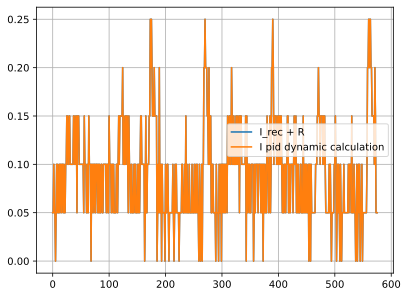

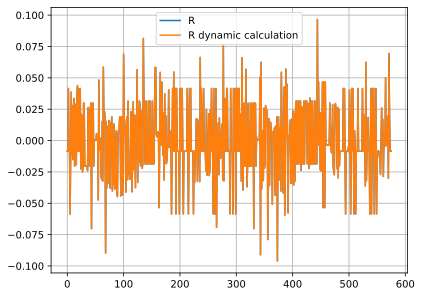

In [5]:
CGM   = (scaler_glucose.denormalize(dataset.CGM.detach())).numpy();              G     = (scaler_glucose.denormalize(dataset.G.detach())).numpy()
                                                                                                                                 
I_sat       = (scaler_insulin.denormalize(dataset.I_sat.detach())).numpy();      I_rec = (scaler_insulin.denormalize(dataset.I_rec.detach())).numpy();       
I_sat_rec   = (scaler_insulin.denormalize(dataset.I_sat_rec.detach())).numpy();  R     = (scaler_insulin.denormalize(dataset.R.detach())).numpy()

M       = (scaler_meal.denormalize(dataset.M.detach())).numpy();                 MH    = (scaler_meal.denormalize(dataset.MH.detach())).numpy();          
MH_rec  = (scaler_meal.denormalize(dataset.MH_rec.detach())).numpy()
H       = (scaler_meal.denormalize(dataset.H.detach())).numpy();                 H_rec = (scaler_meal.denormalize(dataset.H_rec.detach())).numpy();     

# R = I_sat (from .mat) - I_rec (exiting the PID and before saturation and noise)
# if  use_noise = True, R contains the noise and the saturation effect


# ------------------------- PID controller dynamic simulation ---------------------------------------------------
CGM_torch = dataset.CGM
loaded_parameters = Parameter(patient)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
u_pid, u_pid_rwgn, u_pid_rwgn_sat, r = controller(CGM_torch)


u_pid           = scaler_insulin.denormalize(u_pid.detach())
u_pid_rwgn      = scaler_insulin.denormalize(u_pid_rwgn.detach())
u_pid_rwgn_sat  = scaler_insulin.denormalize(u_pid_rwgn_sat.detach())
r               = scaler_insulin.denormalize(r.detach())

plt.figure()
plt.plot(I_rec[:2*1440//ts]+ R[:2*1440//ts], label= 'I_rec + R')
plt.plot(u_pid_rwgn_sat.numpy()[:2*1440//ts], label = 'I pid dynamic calculation');             plt.legend();plt.grid(True); plt.show()

plt.figure()
plt.plot(R[:2*1440//ts], label= 'R')
plt.plot(r.numpy()[:2*1440//ts], label = 'R dynamic calculation');                             plt.legend();plt.grid(True); plt.show()


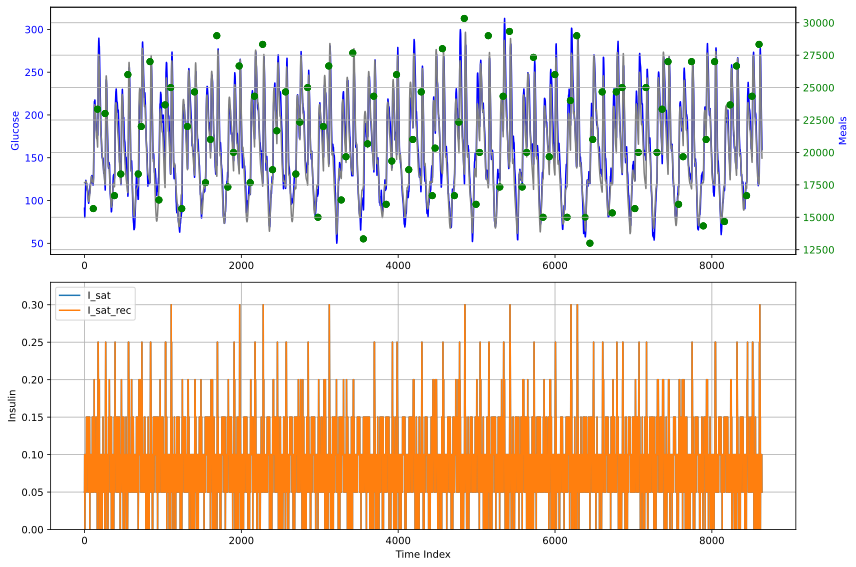

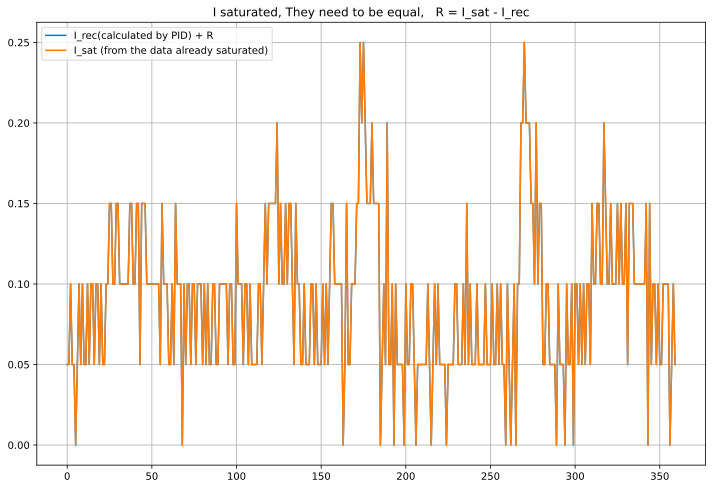

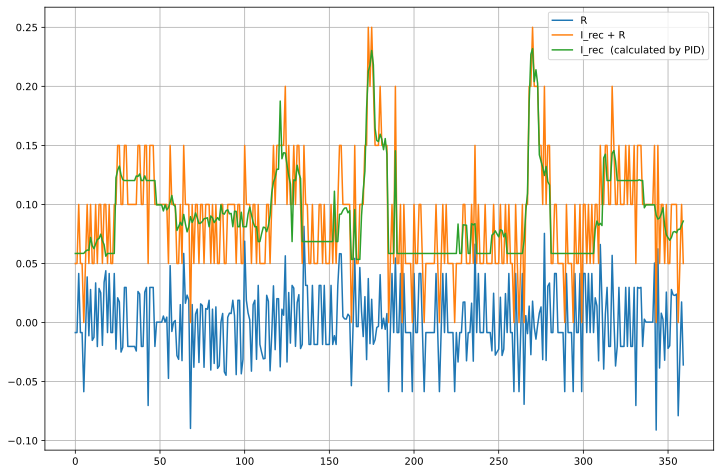

In [6]:
plt.figure(1, figsize=(12, 8))

# Subplot 1
ax1 = plt.subplot(2, 1, 1)
ax1.plot(CGM[:], 'b-', label='Glucose sensor CGM')
ax1.plot(G[:], 'gray', label='Glucose');                                                               ax1.set_ylabel('Glucose', color='b'); ax1.tick_params(axis='y', labelcolor='b'); ax1_right = ax1.twinx()
MHtemp = MH[:].copy()
ax1_right.scatter(np.arange(len(MHtemp))[MHtemp!=0], MHtemp[MHtemp!=0], color='g', label='Meals and hypo');         ax1_right.set_ylabel('Meals', color='b'); ax1_right.tick_params(axis='y', labelcolor='g'); plt.grid(True)

# Subplot 2
ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(range(len(I_sat[:])), I_sat[:].flatten(), label='I_sat')
ax2.plot(range(len(I_sat_rec[:])), I_sat_rec[:], label='I_sat_rec');                                      ax2.set_ylim([0, np.max(I_sat_rec) * 1.1]); ax2.legend(); ax2.set_xlabel('Time Index'); ax2.set_ylabel('Insulin')

plt.tight_layout(); plt.grid(True); plt.show()



plt.figure(3, figsize=(12, 8))
plt.plot(I_rec[:1440//4]+ R[:1440//4], label = 'I_rec(calculated by PID) + R')
plt.plot(I_sat[:1440//4], label= 'I_sat (from the data already saturated)')
plt.title('I saturated, They need to be equal,   R = I_sat - I_rec');                   plt.legend();plt.grid(True); plt.show()

plt.figure(4, figsize=(12, 8))
plt.plot(R[:1440//4], label= 'R')
plt.plot(I_rec[:1440//4]+ R[:1440//4], label= 'I_rec + R')
plt.plot(I_rec[:1440//4], label = 'I_rec  (calculated by PID)');                             plt.legend();plt.grid(True); plt.show()


# plt.figure(5)
# plt.plot(H, label='H')
# plt.plot(H_rec-100, label='H_rec')
# plt.title('Hypoglycemia Treatments Comparison');                                                    plt.legend(); plt.show()
#
# plt.figure(6)
# plt.plot(CGM[:1440//4], 'b-', label='Glucose sensor CGM')
# plt.plot(G[:1440//4], 'gray', label='Glucose')
# plt.figure(1, figsize=(12, 8))


In [7]:
#--------------------------3. Define model for sysid---------------------------------------------


device = torch.device(device if torch.cuda.is_available() else "cpu")

# meal   M 
REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

# insulin  I_sat
REN_1 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)

REN_0 = REN_0.to(device)
REN_1 = REN_1.to(device)

#create the closed loop with the identified model
# closed_loop_G = ClosedLoopSystem(REN_G, controller)

#--------------------------4. Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_1.parameters()),   lr=learning_rate)
optimizer.zero_grad()

C:\Users\pogotar\Desktop\Dottorato\Nonlinear_system_identification_modified\Nonlinear_system_identification_diabetic_patients\Rens.py:313: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4419.)
  self.x = torch.linalg.lstsq(self.C2, y_init.squeeze(1).T)[0].T.unsqueeze(0).unsqueeze(0)


In [8]:
#--------------------------5. Training---------------------------------------------------------------------

torch.set_default_device(device)      # default tensor device
torch.set_default_dtype(torch.float32)  # default tensor dtype
print(f"[INFO] Training on device: {device}")

REN_0.to(device); REN_1.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_1.train()
    loss_epoch = 0.0  # Accumulate training loss

    
    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        REN_0.reset(); REN_1.reset()

        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_1(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()
        optimizer.step()
        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_1.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time

            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_1.reset()

            y0_hat_val = REN_0(u0_batch)
            y1_hat_val = REN_1(u1_batch)# select the correct U
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_1 = REN_1

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_1_cpu = candidate_REN_1.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_1" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_1_state_dict': candidate_REN_1_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})


[INFO] Training on device: cpu


Epoch: 1 	||	 Training Loss: 0.200984 	||	 Validation Loss: 0.214050


Epoch: 2 	||	 Training Loss: 0.199062 	||	 Validation Loss: 0.212064


Epoch: 3 	||	 Training Loss: 0.197121 	||	 Validation Loss: 0.210058


Epoch: 4 	||	 Training Loss: 0.195161 	||	 Validation Loss: 0.208031


Epoch: 5 	||	 Training Loss: 0.193180 	||	 Validation Loss: 0.205982


Epoch: 6 	||	 Training Loss: 0.191179 	||	 Validation Loss: 0.203911


Epoch: 7 	||	 Training Loss: 0.189157 	||	 Validation Loss: 0.201818


Epoch: 8 	||	 Training Loss: 0.187113 	||	 Validation Loss: 0.199700


Epoch: 9 	||	 Training Loss: 0.185047 	||	 Validation Loss: 0.197557


Epoch: 10 	||	 Training Loss: 0.182957 	||	 Validation Loss: 0.195389


Epoch: 11 	||	 Training Loss: 0.180842 	||	 Validation Loss: 0.193193


Epoch: 12 	||	 Training Loss: 0.178701 	||	 Validation Loss: 0.190969


Epoch: 13 	||	 Training Loss: 0.176534 	||	 Validation Loss: 0.188715


Epoch: 14 	||	 Training Loss: 0.174338 	||	 Validation Loss: 0.186429


Epoch: 15 	||	 Training Loss: 0.172112 	||	 Validation Loss: 0.184111


Epoch: 16 	||	 Training Loss: 0.169856 	||	 Validation Loss: 0.181759


Epoch: 17 	||	 Training Loss: 0.167567 	||	 Validation Loss: 0.179370


Epoch: 18 	||	 Training Loss: 0.165244 	||	 Validation Loss: 0.176943


Epoch: 19 	||	 Training Loss: 0.162885 	||	 Validation Loss: 0.174476


Epoch: 20 	||	 Training Loss: 0.160488 	||	 Validation Loss: 0.171968


Epoch: 21 	||	 Training Loss: 0.158052 	||	 Validation Loss: 0.169415


Epoch: 22 	||	 Training Loss: 0.155574 	||	 Validation Loss: 0.166816


Epoch: 23 	||	 Training Loss: 0.153053 	||	 Validation Loss: 0.164168


Epoch: 24 	||	 Training Loss: 0.150486 	||	 Validation Loss: 0.161470


Epoch: 25 	||	 Training Loss: 0.147872 	||	 Validation Loss: 0.158718


Epoch: 26 	||	 Training Loss: 0.145208 	||	 Validation Loss: 0.155912


Epoch: 27 	||	 Training Loss: 0.142493 	||	 Validation Loss: 0.153048


Epoch: 28 	||	 Training Loss: 0.139725 	||	 Validation Loss: 0.150125


Epoch: 29 	||	 Training Loss: 0.136901 	||	 Validation Loss: 0.147140


Epoch: 30 	||	 Training Loss: 0.134020 	||	 Validation Loss: 0.144091


Epoch: 31 	||	 Training Loss: 0.131081 	||	 Validation Loss: 0.140976


Epoch: 32 	||	 Training Loss: 0.128081 	||	 Validation Loss: 0.137794


Epoch: 33 	||	 Training Loss: 0.125019 	||	 Validation Loss: 0.134543


Epoch: 34 	||	 Training Loss: 0.121895 	||	 Validation Loss: 0.131222


Epoch: 35 	||	 Training Loss: 0.118707 	||	 Validation Loss: 0.127830


Epoch: 36 	||	 Training Loss: 0.115455 	||	 Validation Loss: 0.124366


Epoch: 37 	||	 Training Loss: 0.112140 	||	 Validation Loss: 0.120830


Epoch: 38 	||	 Training Loss: 0.108761 	||	 Validation Loss: 0.117223


Epoch: 39 	||	 Training Loss: 0.105321 	||	 Validation Loss: 0.113547


Epoch: 40 	||	 Training Loss: 0.101821 	||	 Validation Loss: 0.109804


Epoch: 41 	||	 Training Loss: 0.098265 	||	 Validation Loss: 0.105997


Epoch: 42 	||	 Training Loss: 0.094658 	||	 Validation Loss: 0.102133


Epoch: 43 	||	 Training Loss: 0.091006 	||	 Validation Loss: 0.098217


Epoch: 44 	||	 Training Loss: 0.087317 	||	 Validation Loss: 0.094260


Epoch: 45 	||	 Training Loss: 0.083601 	||	 Validation Loss: 0.090273


Epoch: 46 	||	 Training Loss: 0.079871 	||	 Validation Loss: 0.086270


Epoch: 47 	||	 Training Loss: 0.076145 	||	 Validation Loss: 0.082271


Epoch: 48 	||	 Training Loss: 0.072441 	||	 Validation Loss: 0.078297


Epoch: 49 	||	 Training Loss: 0.068783 	||	 Validation Loss: 0.074376


Epoch: 50 	||	 Training Loss: 0.065200 	||	 Validation Loss: 0.070539


Epoch: 51 	||	 Training Loss: 0.061726 	||	 Validation Loss: 0.066824


Epoch: 52 	||	 Training Loss: 0.058398 	||	 Validation Loss: 0.063274


Epoch: 53 	||	 Training Loss: 0.055261 	||	 Validation Loss: 0.059934


Epoch: 54 	||	 Training Loss: 0.052361 	||	 Validation Loss: 0.056858


Epoch: 55 	||	 Training Loss: 0.049751 	||	 Validation Loss: 0.054097


Epoch: 56 	||	 Training Loss: 0.047483 	||	 Validation Loss: 0.051704


Epoch: 57 	||	 Training Loss: 0.045606 	||	 Validation Loss: 0.049726


Epoch: 58 	||	 Training Loss: 0.044163 	||	 Validation Loss: 0.048196


Epoch: 59 	||	 Training Loss: 0.043182 	||	 Validation Loss: 0.047129


Epoch: 60 	||	 Training Loss: 0.042665 	||	 Validation Loss: 0.046507


Epoch: 61 	||	 Training Loss: 0.042585 	||	 Validation Loss: 0.046281


Epoch: 62 	||	 Training Loss: 0.042875 	||	 Validation Loss: 0.046361


Epoch: 63 	||	 Training Loss: 0.043426 	||	 Validation Loss: 0.046628


Epoch: 64 	||	 Training Loss: 0.044099 	||	 Validation Loss: 0.046950


Epoch: 65 	||	 Training Loss: 0.044747 	||	 Validation Loss: 0.047210


Epoch: 66 	||	 Training Loss: 0.045237 	||	 Validation Loss: 0.047324


Epoch: 67 	||	 Training Loss: 0.045483 	||	 Validation Loss: 0.047259


Epoch: 68 	||	 Training Loss: 0.045452 	||	 Validation Loss: 0.047026


Epoch: 69 	||	 Training Loss: 0.045164 	||	 Validation Loss: 0.046670


Epoch: 70 	||	 Training Loss: 0.044679 	||	 Validation Loss: 0.046254


Epoch: 71 	||	 Training Loss: 0.044074 	||	 Validation Loss: 0.045840


Epoch: 72 	||	 Training Loss: 0.043430 	||	 Validation Loss: 0.045479


Epoch: 73 	||	 Training Loss: 0.042813 	||	 Validation Loss: 0.045208


Epoch: 74 	||	 Training Loss: 0.042273 	||	 Validation Loss: 0.045042


Epoch: 75 	||	 Training Loss: 0.041837 	||	 Validation Loss: 0.044981


Epoch: 76 	||	 Training Loss: 0.041516 	||	 Validation Loss: 0.045013


Epoch: 77 	||	 Training Loss: 0.041304 	||	 Validation Loss: 0.045118


Epoch: 78 	||	 Training Loss: 0.041186 	||	 Validation Loss: 0.045270


Epoch: 79 	||	 Training Loss: 0.041141 	||	 Validation Loss: 0.045445


Epoch: 80 	||	 Training Loss: 0.041145 	||	 Validation Loss: 0.045619


Epoch: 81 	||	 Training Loss: 0.041178 	||	 Validation Loss: 0.045772


Epoch: 82 	||	 Training Loss: 0.041218 	||	 Validation Loss: 0.045889


Epoch: 83 	||	 Training Loss: 0.041251 	||	 Validation Loss: 0.045960


Epoch: 84 	||	 Training Loss: 0.041265 	||	 Validation Loss: 0.045979


Epoch: 85 	||	 Training Loss: 0.041253 	||	 Validation Loss: 0.045945


Epoch: 86 	||	 Training Loss: 0.041213 	||	 Validation Loss: 0.045860


Epoch: 87 	||	 Training Loss: 0.041144 	||	 Validation Loss: 0.045730


Epoch: 88 	||	 Training Loss: 0.041051 	||	 Validation Loss: 0.045561


Epoch: 89 	||	 Training Loss: 0.040938 	||	 Validation Loss: 0.045363


Epoch: 90 	||	 Training Loss: 0.040811 	||	 Validation Loss: 0.045145


Epoch: 91 	||	 Training Loss: 0.040679 	||	 Validation Loss: 0.044917


Epoch: 92 	||	 Training Loss: 0.040546 	||	 Validation Loss: 0.044687


Epoch: 93 	||	 Training Loss: 0.040420 	||	 Validation Loss: 0.044462


Epoch: 94 	||	 Training Loss: 0.040305 	||	 Validation Loss: 0.044250


Epoch: 95 	||	 Training Loss: 0.040204 	||	 Validation Loss: 0.044053


Epoch: 96 	||	 Training Loss: 0.040118 	||	 Validation Loss: 0.043875


Epoch: 97 	||	 Training Loss: 0.040046 	||	 Validation Loss: 0.043716


Epoch: 98 	||	 Training Loss: 0.039988 	||	 Validation Loss: 0.043576


Epoch: 99 	||	 Training Loss: 0.039939 	||	 Validation Loss: 0.043453


Epoch: 100 	||	 Training Loss: 0.039897 	||	 Validation Loss: 0.043345


Epoch: 101 	||	 Training Loss: 0.039857 	||	 Validation Loss: 0.043250


Epoch: 102 	||	 Training Loss: 0.039816 	||	 Validation Loss: 0.043166


Epoch: 103 	||	 Training Loss: 0.039771 	||	 Validation Loss: 0.043090


Epoch: 104 	||	 Training Loss: 0.039721 	||	 Validation Loss: 0.043022


Epoch: 105 	||	 Training Loss: 0.039664 	||	 Validation Loss: 0.042961


Epoch: 106 	||	 Training Loss: 0.039602 	||	 Validation Loss: 0.042906


Epoch: 107 	||	 Training Loss: 0.039535 	||	 Validation Loss: 0.042859


Epoch: 108 	||	 Training Loss: 0.039465 	||	 Validation Loss: 0.042817


Epoch: 109 	||	 Training Loss: 0.039394 	||	 Validation Loss: 0.042782


Epoch: 110 	||	 Training Loss: 0.039323 	||	 Validation Loss: 0.042753


Epoch: 111 	||	 Training Loss: 0.039255 	||	 Validation Loss: 0.042727


Epoch: 112 	||	 Training Loss: 0.039189 	||	 Validation Loss: 0.042704


Epoch: 113 	||	 Training Loss: 0.039127 	||	 Validation Loss: 0.042682


Epoch: 114 	||	 Training Loss: 0.039068 	||	 Validation Loss: 0.042659


Epoch: 115 	||	 Training Loss: 0.039012 	||	 Validation Loss: 0.042633


Epoch: 116 	||	 Training Loss: 0.038957 	||	 Validation Loss: 0.042603


Epoch: 117 	||	 Training Loss: 0.038904 	||	 Validation Loss: 0.042566


Epoch: 118 	||	 Training Loss: 0.038851 	||	 Validation Loss: 0.042522


Epoch: 119 	||	 Training Loss: 0.038798 	||	 Validation Loss: 0.042470


Epoch: 120 	||	 Training Loss: 0.038744 	||	 Validation Loss: 0.042410


Epoch: 121 	||	 Training Loss: 0.038688 	||	 Validation Loss: 0.042343


Epoch: 122 	||	 Training Loss: 0.038632 	||	 Validation Loss: 0.042269


Epoch: 123 	||	 Training Loss: 0.038574 	||	 Validation Loss: 0.042190


Epoch: 124 	||	 Training Loss: 0.038516 	||	 Validation Loss: 0.042106


Epoch: 125 	||	 Training Loss: 0.038457 	||	 Validation Loss: 0.042019


Epoch: 126 	||	 Training Loss: 0.038399 	||	 Validation Loss: 0.041930


Epoch: 127 	||	 Training Loss: 0.038341 	||	 Validation Loss: 0.041841


Epoch: 128 	||	 Training Loss: 0.038283 	||	 Validation Loss: 0.041753


Epoch: 129 	||	 Training Loss: 0.038227 	||	 Validation Loss: 0.041667


Epoch: 130 	||	 Training Loss: 0.038171 	||	 Validation Loss: 0.041583


Epoch: 131 	||	 Training Loss: 0.038116 	||	 Validation Loss: 0.041502


Epoch: 132 	||	 Training Loss: 0.038062 	||	 Validation Loss: 0.041425


Epoch: 133 	||	 Training Loss: 0.038008 	||	 Validation Loss: 0.041351


Epoch: 134 	||	 Training Loss: 0.037954 	||	 Validation Loss: 0.041280


Epoch: 135 	||	 Training Loss: 0.037900 	||	 Validation Loss: 0.041214


Epoch: 136 	||	 Training Loss: 0.037846 	||	 Validation Loss: 0.041151


Epoch: 137 	||	 Training Loss: 0.037792 	||	 Validation Loss: 0.041091


Epoch: 138 	||	 Training Loss: 0.037738 	||	 Validation Loss: 0.041034


Epoch: 139 	||	 Training Loss: 0.037683 	||	 Validation Loss: 0.040979


Epoch: 140 	||	 Training Loss: 0.037629 	||	 Validation Loss: 0.040927


Epoch: 141 	||	 Training Loss: 0.037575 	||	 Validation Loss: 0.040876


Epoch: 142 	||	 Training Loss: 0.037521 	||	 Validation Loss: 0.040825


Epoch: 143 	||	 Training Loss: 0.037468 	||	 Validation Loss: 0.040775


Epoch: 144 	||	 Training Loss: 0.037415 	||	 Validation Loss: 0.040725


Epoch: 145 	||	 Training Loss: 0.037362 	||	 Validation Loss: 0.040674


Epoch: 146 	||	 Training Loss: 0.037310 	||	 Validation Loss: 0.040621


Epoch: 147 	||	 Training Loss: 0.037258 	||	 Validation Loss: 0.040567


Epoch: 148 	||	 Training Loss: 0.037206 	||	 Validation Loss: 0.040512


Epoch: 149 	||	 Training Loss: 0.037154 	||	 Validation Loss: 0.040454


Epoch: 150 	||	 Training Loss: 0.037103 	||	 Validation Loss: 0.040394


Epoch: 151 	||	 Training Loss: 0.037051 	||	 Validation Loss: 0.040332


Epoch: 152 	||	 Training Loss: 0.037000 	||	 Validation Loss: 0.040269


Epoch: 153 	||	 Training Loss: 0.036949 	||	 Validation Loss: 0.040205


Epoch: 154 	||	 Training Loss: 0.036898 	||	 Validation Loss: 0.040140


Epoch: 155 	||	 Training Loss: 0.036847 	||	 Validation Loss: 0.040074


Epoch: 156 	||	 Training Loss: 0.036797 	||	 Validation Loss: 0.040009


Epoch: 157 	||	 Training Loss: 0.036746 	||	 Validation Loss: 0.039943


Epoch: 158 	||	 Training Loss: 0.036697 	||	 Validation Loss: 0.039879


Epoch: 159 	||	 Training Loss: 0.036647 	||	 Validation Loss: 0.039815


Epoch: 160 	||	 Training Loss: 0.036598 	||	 Validation Loss: 0.039753


Epoch: 161 	||	 Training Loss: 0.036549 	||	 Validation Loss: 0.039692


Epoch: 162 	||	 Training Loss: 0.036500 	||	 Validation Loss: 0.039632


Epoch: 163 	||	 Training Loss: 0.036451 	||	 Validation Loss: 0.039574


Epoch: 164 	||	 Training Loss: 0.036403 	||	 Validation Loss: 0.039517


Epoch: 165 	||	 Training Loss: 0.036355 	||	 Validation Loss: 0.039461


Epoch: 166 	||	 Training Loss: 0.036307 	||	 Validation Loss: 0.039407


Epoch: 167 	||	 Training Loss: 0.036259 	||	 Validation Loss: 0.039353


Epoch: 168 	||	 Training Loss: 0.036212 	||	 Validation Loss: 0.039300


Epoch: 169 	||	 Training Loss: 0.036165 	||	 Validation Loss: 0.039248


Epoch: 170 	||	 Training Loss: 0.036118 	||	 Validation Loss: 0.039196


Epoch: 171 	||	 Training Loss: 0.036072 	||	 Validation Loss: 0.039144


Epoch: 172 	||	 Training Loss: 0.036026 	||	 Validation Loss: 0.039092


Epoch: 173 	||	 Training Loss: 0.035980 	||	 Validation Loss: 0.039039


Epoch: 174 	||	 Training Loss: 0.035934 	||	 Validation Loss: 0.038986


Epoch: 175 	||	 Training Loss: 0.035889 	||	 Validation Loss: 0.038933


Epoch: 176 	||	 Training Loss: 0.035844 	||	 Validation Loss: 0.038879


Epoch: 177 	||	 Training Loss: 0.035800 	||	 Validation Loss: 0.038825


Epoch: 178 	||	 Training Loss: 0.035755 	||	 Validation Loss: 0.038771


Epoch: 179 	||	 Training Loss: 0.035711 	||	 Validation Loss: 0.038716


Epoch: 180 	||	 Training Loss: 0.035668 	||	 Validation Loss: 0.038662


Epoch: 181 	||	 Training Loss: 0.035624 	||	 Validation Loss: 0.038607


Epoch: 182 	||	 Training Loss: 0.035581 	||	 Validation Loss: 0.038553


Epoch: 183 	||	 Training Loss: 0.035538 	||	 Validation Loss: 0.038499


Epoch: 184 	||	 Training Loss: 0.035496 	||	 Validation Loss: 0.038446


Epoch: 185 	||	 Training Loss: 0.035454 	||	 Validation Loss: 0.038394


Epoch: 186 	||	 Training Loss: 0.035412 	||	 Validation Loss: 0.038342


Epoch: 187 	||	 Training Loss: 0.035371 	||	 Validation Loss: 0.038291


Epoch: 188 	||	 Training Loss: 0.035330 	||	 Validation Loss: 0.038241


Epoch: 189 	||	 Training Loss: 0.035289 	||	 Validation Loss: 0.038192


Epoch: 190 	||	 Training Loss: 0.035248 	||	 Validation Loss: 0.038143


Epoch: 191 	||	 Training Loss: 0.035208 	||	 Validation Loss: 0.038095


Epoch: 192 	||	 Training Loss: 0.035169 	||	 Validation Loss: 0.038047


Epoch: 193 	||	 Training Loss: 0.035129 	||	 Validation Loss: 0.038000


Epoch: 194 	||	 Training Loss: 0.035090 	||	 Validation Loss: 0.037953


Epoch: 195 	||	 Training Loss: 0.035052 	||	 Validation Loss: 0.037907


Epoch: 196 	||	 Training Loss: 0.035013 	||	 Validation Loss: 0.037860


Epoch: 197 	||	 Training Loss: 0.034975 	||	 Validation Loss: 0.037814


Epoch: 198 	||	 Training Loss: 0.034938 	||	 Validation Loss: 0.037768


Epoch: 199 	||	 Training Loss: 0.034901 	||	 Validation Loss: 0.037722


Epoch: 200 	||	 Training Loss: 0.034864 	||	 Validation Loss: 0.037676


Epoch: 201 	||	 Training Loss: 0.034827 	||	 Validation Loss: 0.037630


Epoch: 202 	||	 Training Loss: 0.034791 	||	 Validation Loss: 0.037584


Epoch: 203 	||	 Training Loss: 0.034756 	||	 Validation Loss: 0.037539


Epoch: 204 	||	 Training Loss: 0.034720 	||	 Validation Loss: 0.037494


Epoch: 205 	||	 Training Loss: 0.034685 	||	 Validation Loss: 0.037449


Epoch: 206 	||	 Training Loss: 0.034651 	||	 Validation Loss: 0.037405


Epoch: 207 	||	 Training Loss: 0.034616 	||	 Validation Loss: 0.037361


Epoch: 208 	||	 Training Loss: 0.034583 	||	 Validation Loss: 0.037318


Epoch: 209 	||	 Training Loss: 0.034549 	||	 Validation Loss: 0.037276


Epoch: 210 	||	 Training Loss: 0.034516 	||	 Validation Loss: 0.037234


Epoch: 211 	||	 Training Loss: 0.034483 	||	 Validation Loss: 0.037192


Epoch: 212 	||	 Training Loss: 0.034451 	||	 Validation Loss: 0.037151


Epoch: 213 	||	 Training Loss: 0.034419 	||	 Validation Loss: 0.037111


Epoch: 214 	||	 Training Loss: 0.034387 	||	 Validation Loss: 0.037071


Epoch: 215 	||	 Training Loss: 0.034356 	||	 Validation Loss: 0.037032


Epoch: 216 	||	 Training Loss: 0.034325 	||	 Validation Loss: 0.036992


Epoch: 217 	||	 Training Loss: 0.034295 	||	 Validation Loss: 0.036954


Epoch: 218 	||	 Training Loss: 0.034265 	||	 Validation Loss: 0.036915


Epoch: 219 	||	 Training Loss: 0.034235 	||	 Validation Loss: 0.036877


Epoch: 220 	||	 Training Loss: 0.034206 	||	 Validation Loss: 0.036839


Epoch: 221 	||	 Training Loss: 0.034177 	||	 Validation Loss: 0.036801


Epoch: 222 	||	 Training Loss: 0.034148 	||	 Validation Loss: 0.036764


Epoch: 223 	||	 Training Loss: 0.034120 	||	 Validation Loss: 0.036727


Epoch: 224 	||	 Training Loss: 0.034092 	||	 Validation Loss: 0.036690


Epoch: 225 	||	 Training Loss: 0.034065 	||	 Validation Loss: 0.036654


Epoch: 226 	||	 Training Loss: 0.034038 	||	 Validation Loss: 0.036618


Epoch: 227 	||	 Training Loss: 0.034011 	||	 Validation Loss: 0.036583


Epoch: 228 	||	 Training Loss: 0.033985 	||	 Validation Loss: 0.036548


Epoch: 229 	||	 Training Loss: 0.033959 	||	 Validation Loss: 0.036514


Epoch: 230 	||	 Training Loss: 0.033934 	||	 Validation Loss: 0.036480


Epoch: 231 	||	 Training Loss: 0.033908 	||	 Validation Loss: 0.036446


Epoch: 232 	||	 Training Loss: 0.033884 	||	 Validation Loss: 0.036414


Epoch: 233 	||	 Training Loss: 0.033859 	||	 Validation Loss: 0.036381


Epoch: 234 	||	 Training Loss: 0.033835 	||	 Validation Loss: 0.036349


Epoch: 235 	||	 Training Loss: 0.033811 	||	 Validation Loss: 0.036317


Epoch: 236 	||	 Training Loss: 0.033788 	||	 Validation Loss: 0.036286


Epoch: 237 	||	 Training Loss: 0.033765 	||	 Validation Loss: 0.036255


Epoch: 238 	||	 Training Loss: 0.033742 	||	 Validation Loss: 0.036225


Epoch: 239 	||	 Training Loss: 0.033720 	||	 Validation Loss: 0.036194


Epoch: 240 	||	 Training Loss: 0.033698 	||	 Validation Loss: 0.036164


Epoch: 241 	||	 Training Loss: 0.033676 	||	 Validation Loss: 0.036135


Epoch: 242 	||	 Training Loss: 0.033655 	||	 Validation Loss: 0.036106


Epoch: 243 	||	 Training Loss: 0.033634 	||	 Validation Loss: 0.036077


Epoch: 244 	||	 Training Loss: 0.033614 	||	 Validation Loss: 0.036048


Epoch: 245 	||	 Training Loss: 0.033593 	||	 Validation Loss: 0.036020


Epoch: 246 	||	 Training Loss: 0.033573 	||	 Validation Loss: 0.035993


Epoch: 247 	||	 Training Loss: 0.033554 	||	 Validation Loss: 0.035965


Epoch: 248 	||	 Training Loss: 0.033535 	||	 Validation Loss: 0.035939


Epoch: 249 	||	 Training Loss: 0.033516 	||	 Validation Loss: 0.035912


Epoch: 250 	||	 Training Loss: 0.033497 	||	 Validation Loss: 0.035886


Epoch: 251 	||	 Training Loss: 0.033479 	||	 Validation Loss: 0.035861


Epoch: 252 	||	 Training Loss: 0.033461 	||	 Validation Loss: 0.035835


Epoch: 253 	||	 Training Loss: 0.033443 	||	 Validation Loss: 0.035810


Epoch: 254 	||	 Training Loss: 0.033425 	||	 Validation Loss: 0.035786


Epoch: 255 	||	 Training Loss: 0.033408 	||	 Validation Loss: 0.035762


Epoch: 256 	||	 Training Loss: 0.033391 	||	 Validation Loss: 0.035738


Epoch: 257 	||	 Training Loss: 0.033375 	||	 Validation Loss: 0.035714


Epoch: 258 	||	 Training Loss: 0.033359 	||	 Validation Loss: 0.035691


Epoch: 259 	||	 Training Loss: 0.033343 	||	 Validation Loss: 0.035668


Epoch: 260 	||	 Training Loss: 0.033327 	||	 Validation Loss: 0.035646


Epoch: 261 	||	 Training Loss: 0.033312 	||	 Validation Loss: 0.035623


Epoch: 262 	||	 Training Loss: 0.033296 	||	 Validation Loss: 0.035601


Epoch: 263 	||	 Training Loss: 0.033281 	||	 Validation Loss: 0.035580


Epoch: 264 	||	 Training Loss: 0.033267 	||	 Validation Loss: 0.035558


Epoch: 265 	||	 Training Loss: 0.033252 	||	 Validation Loss: 0.035537


Epoch: 266 	||	 Training Loss: 0.033238 	||	 Validation Loss: 0.035517


Epoch: 267 	||	 Training Loss: 0.033224 	||	 Validation Loss: 0.035497


Epoch: 268 	||	 Training Loss: 0.033211 	||	 Validation Loss: 0.035477


Epoch: 269 	||	 Training Loss: 0.033197 	||	 Validation Loss: 0.035457


Epoch: 270 	||	 Training Loss: 0.033184 	||	 Validation Loss: 0.035438


Epoch: 271 	||	 Training Loss: 0.033171 	||	 Validation Loss: 0.035419


Epoch: 272 	||	 Training Loss: 0.033159 	||	 Validation Loss: 0.035400


Epoch: 273 	||	 Training Loss: 0.033146 	||	 Validation Loss: 0.035381


Epoch: 274 	||	 Training Loss: 0.033134 	||	 Validation Loss: 0.035363


Epoch: 275 	||	 Training Loss: 0.033122 	||	 Validation Loss: 0.035345


Epoch: 276 	||	 Training Loss: 0.033110 	||	 Validation Loss: 0.035327


Epoch: 277 	||	 Training Loss: 0.033098 	||	 Validation Loss: 0.035310


Epoch: 278 	||	 Training Loss: 0.033087 	||	 Validation Loss: 0.035292


Epoch: 279 	||	 Training Loss: 0.033076 	||	 Validation Loss: 0.035276


Epoch: 280 	||	 Training Loss: 0.033065 	||	 Validation Loss: 0.035259


Epoch: 281 	||	 Training Loss: 0.033054 	||	 Validation Loss: 0.035242


Epoch: 282 	||	 Training Loss: 0.033043 	||	 Validation Loss: 0.035226


Epoch: 283 	||	 Training Loss: 0.033033 	||	 Validation Loss: 0.035210


Epoch: 284 	||	 Training Loss: 0.033022 	||	 Validation Loss: 0.035195


Epoch: 285 	||	 Training Loss: 0.033012 	||	 Validation Loss: 0.035179


Epoch: 286 	||	 Training Loss: 0.033002 	||	 Validation Loss: 0.035164


Epoch: 287 	||	 Training Loss: 0.032992 	||	 Validation Loss: 0.035149


Epoch: 288 	||	 Training Loss: 0.032983 	||	 Validation Loss: 0.035134


Epoch: 289 	||	 Training Loss: 0.032973 	||	 Validation Loss: 0.035120


Epoch: 290 	||	 Training Loss: 0.032964 	||	 Validation Loss: 0.035105


In [ ]:
# --------------Plot identification results for G-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)
REN_0.to("cpu"); REN_1.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time:
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch)
    u0_batch, u1_batch, y_batch = u0_batch.to("cpu"), u1_batch.to("cpu"), y_batch.to("cpu")
    # Plot comparison between real and predicted for training set
    REN_0.eval(); REN_1.eval()

    y0_hat = REN_0(u0_batch)
    y1_hat = REN_1(u1_batch)# select the correct U
    y_hat = y0_hat - y1_hat
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S

y_init = x0


REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)
Dual_REN = DualREN(REN_0, REN_S, device=device)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_1 = ClosedLoopSystem(closed_loop_REN, controller)



#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(Dual_REN.parameters(), lr=learning_rate)
optimizer.zero_grad()

In [ ]:
#--------------------------5. Training---------------------------------------------------------------------


REN_0 = REN_0.to(device)
REN_S = REN_S.to(device)
Dual_Ren = Dual_REN.to(device)
controller = controller.to(device)
closed_loop_REN = closed_loop_REN.to(device)
x0 = x0.to(device)
print(f"[INFO] Training on device: {device}")

closed_loop_closed_loop_1 = closed_loop_closed_loop_1.to("cpu") # test always on cpu?
torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs

for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    closed_loop_REN.train()
    loss_epoch = 0.0  # Accumulate training loss


    for u0_batch, _, _, u1_batch, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        
        u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
        u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension

        optimizer.zero_grad()
        
        Dual_REN.reset(); 
        # closed_loop_REN.reset() ?
        
        _, y_hat_train = closed_loop_REN(x0, u_batch)

        if torch.isnan(y_hat_train).any() or torch.isinf(y_hat_train).any():
            y_hat_train = torch.nan_to_num(y_hat_train, nan=1e5, posinf=1e5, neginf=-1e5)
            for name, param in closed_loop_REN.named_parameters():
                print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

        loss_batch = MSE(y_hat_train, y_batch)

        loss_batch.backward()

        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    Dual_REN.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, _, u1_batch, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)
            
            Dual_REN.reset(); 

            _, y_hat_val = closed_loop_REN(x0, u_batch)
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_Dual_REN = Dual_REN

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_Dual_REN_cpu = candidate_Dual_REN.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_2" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'Dueal_REN_state_dict': candidate_Dual_REN_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})

In [ ]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

Dual_REN.to("cpu"); closed_loop_REN.to("cpu")
    

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    Dual_REN.eval()
    _, y_hat = closed_loop_REN(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S
y_init = x0

REN_0 = REN_IQC_gamma(dim_in= input_dim[0], dim_out= output_dim[0], dim_internal=dim_internal[0], dim_nl= dim_nl[0], y_init = y_init[0], QR_fun = set_QR, gammat=gamma[0], IQC_type = IQC_type[0], device=device)

REN_S_2 = REN_IQC_gamma(dim_in= input_dim[1], dim_out= output_dim[1], dim_internal=dim_internal[1], dim_nl= dim_nl[1], y_init = y_init[1], QR_fun = set_QR, gammat=gamma[1], IQC_type = IQC_type[1], device=device)


#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam( list(REN_0.parameters()) + list(REN_S_2.parameters()),   lr=learning_rate)
optimizer.zero_grad()

In [ ]:
#--------------------------5. Training---------------------------------------------------------------------

REN_0 = REN_0.to(device)
REN_S_2 = REN_S_2.to(device)
print(f"[INFO] Training on device: {device}")

torch.set_default_dtype(torch.float32)  # default tensor dtype

train_losses = []
val_losses = []  # Store validation losses across epochs


for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_0.train(); REN_S_2.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u0_batch, _, u1_batch, _, y_batch, _ in train_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
        # u_batch.shape = batch_size   horizon   input_dim
        u0_batch, u1_batch, y_batch = ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
        u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)


        optimizer.zero_grad()
        REN_0.reset(); REN_S_2.reset()
        
        
        y0_hat_train = REN_0(u0_batch) # forward
        y1_hat_train = REN_S_2(u1_batch) # forward
        y_hat_train = y0_hat_train - y1_hat_train 
        # with monotonicity we have forced a positive response from the insulin REN (REN_1) 
        # but from real-world knowledge it is a negative relation

        loss_batch = MSE(y_hat_train, y_batch)
        
        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_0.eval(); REN_S_2.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u0_batch, _, u1_batch, _, y_batch, _ in val_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
            # u_batch.shape = batch_size   horizon   input_dim
            
            u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
            u0_batch, u1_batch, y_batch = u0_batch.to(device), u1_batch.to(device), y_batch.to(device)
            
            REN_0.reset(); REN_S_2.reset()
            
            y0_hat_val = REN_0(u0_batch) # forward
            y1_hat_val = REN_S_2(u1_batch) # forward
            y_hat_val = y0_hat_val - y1_hat_val
            
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    if epoch == 0 or loss_val_epoch < min_val_loss:
        min_val_loss = loss_val_epoch
        epoch_when_model_saved = epoch
        candidate_REN_0 = REN_0
        candidate_REN_S_2 = REN_S_2

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

if redo_save:
    # model on CPU before saving
    candidate_REN_0_cpu = candidate_REN_0.to('cpu')
    candidate_REN_S_2_cpu = candidate_REN_S_2.to('cpu')

    # Save the best model
    # 1. Create models directory
    patient_str = "/paz_" + str(int(patient)).zfill(3)
    patient_model_folder = model_folder + "/"+ "strategy_3" + "/" + patient_str
    MODEL_PATH = Path(patient_model_folder)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    # 2. save model state dict
    torch.save({
    'REN_0_state_dict': candidate_REN_0_cpu.state_dict(),
    'REN_S_2_state_dict': candidate_REN_S_2_cpu.state_dict()}, MODEL_PATH / 'trained_models.pth')


    # save .mat
    np_x0 = x0.detach().cpu().numpy(); np_input_dim = np.array(input_dim); np_output_dim = np.array(output_dim); np_dim_internal =np.array(dim_internal); np_dim_nl = np.array(dim_nl)
    np_y_init = y_init.cpu().numpy(); np_gamma = gamma.cpu().numpy()
    
    # 4. Create params directory
    params_folder = Path(patient_model_folder) / "params"
    params_folder.mkdir(parents=True, exist_ok=True)
    scipy.io.savemat(params_folder / 'parameters.mat', {'train_losses': train_losses, 'val_losses': val_losses, 'epoch_when_model_saved': epoch_when_model_saved, 'x0': np_x0, 'input_dim': np_input_dim, 'output_dim': np_output_dim, 'dim_internal': np_dim_internal, 'dim_nl': np_dim_nl, 'y_init': np_y_init, 'gamma': np_gamma})
    
Dual_REN = DualREN(candidate_REN_0_cpu, candidate_REN_S_2_cpu)
controller = NonLinearController(loaded_parameters, PID_functions, dataset.basal_vec, scaler_glucose, scaler_insulin, scaler_meal, use_noise)
closed_loop_REN_2 = ClosedLoopSystem(Dual_REN, controller, negative=True)

closed_loop_closed_loop_2 = ClosedLoopSystem(closed_loop_REN_2, controller)

In [ ]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

closed_loop_REN_2.to("cpu")

for u0_batch, _, _, u1_batch, y_batch, time in test_loader: # MH, I_rec (PID), R (noise + sat), I_sat (I_rec + R), CGM, time
    # u_batch.shape = batch_size   horizon   input_dim
    
    u0_batch, u1_batch, y_batch= ensure_3d(u0_batch), ensure_3d(u1_batch), ensure_3d(y_batch) # batch_size, time_horizon, input_dim
    u_batch = torch.cat((u0_batch, u1_batch), dim=2)  # concatenate along input dimension
    u_batch, y_batch = u_batch.to("cpu"), y_batch.to("cpu")
    

    closed_loop_REN_2.eval()
    _, y_hat = closed_loop_REN_2(x0, u_batch)
    
    loss_batch_val = MSE(y_batch, y_hat)

    loss_val_epoch += loss_batch_val.item()
    
    y_batch_np = scaler_glucose.denormalize(y_batch.detach().cpu()).numpy()
    y_hat_np = scaler_glucose.denormalize(y_hat.detach().cpu()).numpy()
    


plt.plot(time, y_batch_np[0, :, 0], label="Real Output", color="blue")
plt.plot(time, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
plt.title(f"Train Set")
plt.xlabel("Time (s)")
plt.ylabel("Output Value")
plt.legend()
plt.grid(True)
plt.show()